In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, kendalltau
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


In [161]:

data = pd.read_csv('data.csv')  # Replace with the actual path to your dataset


In [ ]:
# For Youtube Videos Data in US and INDIA
data = data[data['country'].isin(['US', 'IN'])]
data = data.dropna()

In [163]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 27318 entries, 301 to 2243935
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            27318 non-null  object
 1   channel_name     27318 non-null  object
 2   daily_rank       27318 non-null  int64 
 3   daily_movement   27318 non-null  int64 
 4   weekly_movement  27318 non-null  int64 
 5   snapshot_date    27318 non-null  object
 6   country          27318 non-null  object
 7   view_count       27318 non-null  int64 
 8   like_count       27318 non-null  int64 
 9   comment_count    27318 non-null  int64 
 10  description      27318 non-null  object
 11  thumbnail_url    27318 non-null  object
 12  video_id         27318 non-null  object
 13  channel_id       27318 non-null  object
 14  video_tags       27318 non-null  object
 15  kind             27318 non-null  object
 16  publish_date     27318 non-null  object
 17  langauge         27318 non-null 

/tmp/ipykernel_397912/1764196500.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(0, inplace=True)


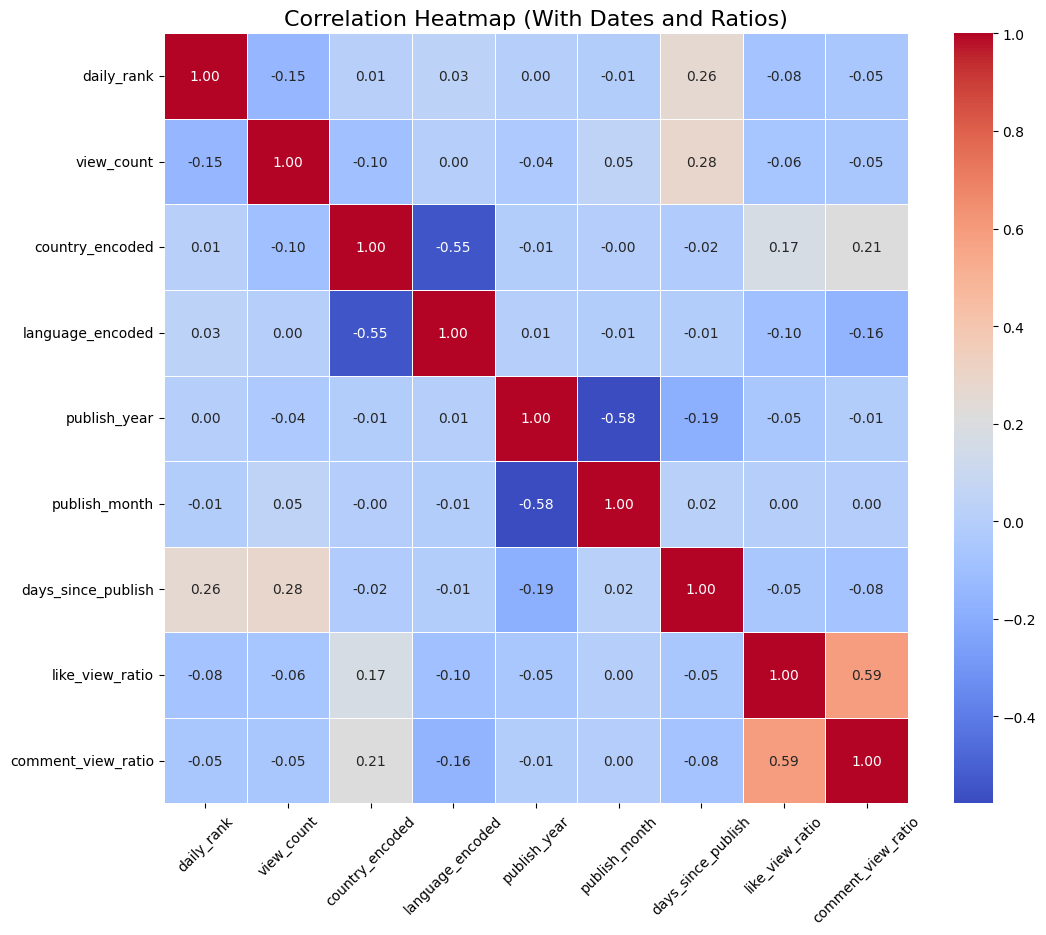

In [164]:

# Ensure 'snapshot_date' and 'publish_date' are in datetime format
data['snapshot_date'] = pd.to_datetime(data['snapshot_date'], errors='coerce').dt.tz_localize(None)
data['publish_date'] = pd.to_datetime(data['publish_date'], errors='coerce').dt.tz_localize(None)

# Create new date-based features
data['publish_year'] = data['publish_date'].dt.year
data['publish_month'] = data['publish_date'].dt.month
data['days_since_publish'] = (data['snapshot_date'] - data['publish_date']).dt.days

# Handle missing or negative values in 'days_since_publish'
data['days_since_publish'] = data['days_since_publish'].apply(lambda x: x if x >= 0 else None)

# Add ratio-based features
data['like_view_ratio'] = data['like_count'] / data['view_count']
data['comment_view_ratio'] = data['comment_count'] / data['view_count']
data['comment_like_ratio'] = data['comment_count'] / data['like_count']

# Replace infinities and NaN values in ratio columns
data.replace([float('inf'), -float('inf')], None, inplace=True)
data.fillna(0, inplace=True)


# Encode categorical features
label_encoder_country = LabelEncoder()
label_encoder_language = LabelEncoder()

data['country_encoded'] = label_encoder_country.fit_transform(data['country'])
data['language_encoded'] = label_encoder_language.fit_transform(data['langauge'].fillna('Unknown'))

# Select updated features for the heatmap
selected_features = ['daily_rank','view_count',
                     'country_encoded', 'language_encoded', 'publish_year', 'publish_month', 'days_since_publish',
                     'like_view_ratio', 'comment_view_ratio']

# Compute the correlation matrix
correlation = data[selected_features].corr()

# Plot the updated heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add titles and labels
plt.title("Correlation Heatmap (With Dates and Ratios)", fontsize=16)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()


In [165]:
# # Select updated features for the heatmap
# selected_features = ['weekly_movement','view_count',
#                      'country_encoded', 'language_encoded', 'publish_year', 'publish_month', 'days_since_publish',
#                      'like_view_ratio', 'comment_view_ratio']

# # Compute the correlation matrix
# correlation = data[selected_features].corr()

# # Plot the updated heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# # Add titles and labels
# plt.title("Correlation Heatmap (With Dates and Ratios)", fontsize=16)
# plt.xticks(fontsize=10, rotation=45)
# plt.yticks(fontsize=10)
# plt.show()

In [166]:
# # Select updated features for the heatmap
# selected_features = ['daily_movement','view_count',
#                      'country_encoded', 'language_encoded', 'publish_year', 'publish_month', 'days_since_publish',
#                      'like_view_ratio', 'comment_view_ratio']

# # Compute the correlation matrix
# correlation = data[selected_features].corr()

# # Plot the updated heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# # Add titles and labels
# plt.title("Correlation Heatmap (With Dates and Ratios)", fontsize=16)
# plt.xticks(fontsize=10, rotation=45)
# plt.yticks(fontsize=10)
# plt.show()

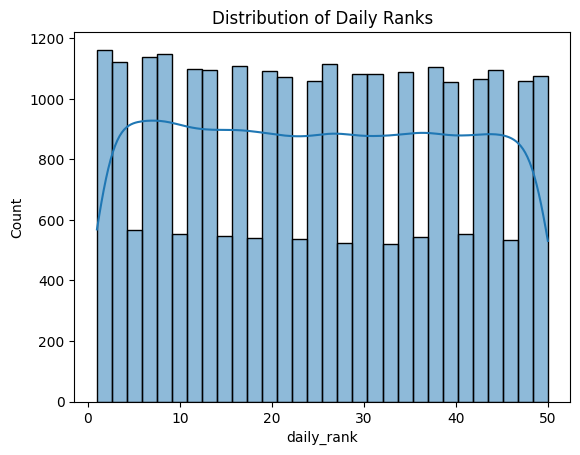

In [167]:
sns.histplot(data['daily_rank'], kde=True)
plt.title("Distribution of Daily Ranks")
plt.show()


In [168]:

# Select features and target
X = data[selected_features].drop(columns=['daily_rank'])  # Features
y = data['daily_rank']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_test = np.array(y_test)


In [169]:
def evaluate_accuracy(y_pred, y_test):

    # Convert predictions to integers
    y_pred_to_int = [int(round(y)) for y in y_pred]
    
    # Calculate the absolute differences
    diff = [abs(y_test[i] - y_pred_to_int[i]) for i in range(len(y_test))]
    
    # Count predictions within the offset
    total_within_offset = sum(1 for d in diff if d <= 5)
    accuracy_within_offset = total_within_offset / len(y_pred_to_int) * 100
    
    # Print the accuracy
    print(f"Accuracy: {accuracy_within_offset:.2f}%")


In [170]:
def evaluate_custom_error(y_pred, y_test):

    # Custom error calculation
    diff2 = [abs((y_test[i] - y_pred[i]) * (y_test[i] - 50)) for i in range(len(y_test))]
    diff2 = [item / 50 for item in diff2]
    diff2 = [int(round(item)) for item in diff2]
    
    # Count predictions within the offset
    total_within_offset = sum(1 for d in diff2 if d <= 5)
    accuracy_within_offset = total_within_offset / len(y_pred) * 100
    
    # Print the accuracy
    print(f"Weighted Accuracy: {accuracy_within_offset:.2f}%")



In [171]:
def evaluate_rank_metrics(y_pred, y_test, k=None):
    # Ensure predictions are rounded to integers
    y_pred_to_int = [int(round(y)) for y in y_pred]
    
    # Calculate Spearman's rank correlation
    spearman_corr, _ = spearmanr(y_test, y_pred_to_int)
    print(f"Spearman's Rank Correlation: {spearman_corr:.4f}")
    
    # Calculate Kendall's tau
    kendall_corr, _ = kendalltau(y_test, y_pred_to_int)
    print(f"Kendall's Tau: {kendall_corr:.4f}")
    
    # Calculate nDCG
    def ndcg_score(y_true, y_pred, k=None):
        # Sort true and predicted values by predicted order
        ideal_sorted = sorted(y_true, reverse=True)
        predicted_sorted = [y_true[i] for i in np.argsort(y_pred)[::-1]]

        # Limit to top-k if k is specified
        if k is not None:
            ideal_sorted = ideal_sorted[:k]
            predicted_sorted = predicted_sorted[:k]
        
        # Compute DCG
        def dcg(scores):
            return sum((rel / np.log2(idx + 2)) for idx, rel in enumerate(scores))
        
        dcg_predicted = dcg(predicted_sorted)
        dcg_ideal = dcg(ideal_sorted)
        
        # Avoid division by zero
        return dcg_predicted / dcg_ideal if dcg_ideal > 0 else 0.0

    ndcg = ndcg_score(y_test, y_pred_to_int, k)
    if k:
        print(f"nDCG@{k}: {ndcg:.4f}")
    else:
        print(f"nDCG: {ndcg:.4f}")




In [172]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pickle

# Initialize and train the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Save the model 
filename = 'linear_model.pkl'
pickle.dump(linear_model, open(filename, 'wb'))

# with open('linear_model.pkl', 'rb') as file:
#     linear_model = pickle.load(file)

# Predictions
y_pred_linear = linear_model.predict(X_test)



In [173]:

# Metrics
print("Linear Regression Results")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_linear)))
print("R2 Score:", r2_score(y_test, y_pred_linear))
evaluate_accuracy(y_pred_linear, y_test)
evaluate_custom_error(y_pred_linear, y_test)
evaluate_rank_metrics(y_pred_linear, y_test)

Linear Regression Results
RMSE: 13.525353554331893
R2 Score: 0.1331373670850191
Accuracy: 24.32%
Weighted Accuracy: 66.98%
Spearman's Rank Correlation: 0.4037
Kendall's Tau: 0.2887
nDCG: 0.9533


In [174]:
# Initialize and train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

filename = 'random_forest_model.pkl'
pickle.dump(rf_model, open(filename, 'wb'))

# Predictions
y_pred_rf = rf_model.predict(X_test)

In [175]:

# Metrics
print("Random Forest Results")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2 Score:", r2_score(y_test, y_pred_rf))
evaluate_accuracy(y_pred_rf, y_test)
evaluate_custom_error(y_pred_rf, y_test)
evaluate_rank_metrics(y_pred_rf, y_test)

Random Forest Results
RMSE: 11.44442635126448
R2 Score: 0.3793581067487847
Accuracy: 34.19%
Weighted Accuracy: 71.49%
Spearman's Rank Correlation: 0.6147
Kendall's Tau: 0.4487
nDCG: 0.9729


In [176]:
# y_pred_to_int = [int(round(y)) for y in y_pred_rf]
# diff = [abs(y_test[i] - y_pred_to_int[i]) for i in range(len(y_test))]
# # count number of predictions that are off by more than 2
# count = {}
# for d in diff:
#     if (d in count):
#         count[d] += 1
#     else:
#         count[d] = 1
# # sort the count dictionary by key
# count = dict(sorted(count.items()))
# total = 0
# for i, j in count.items():
#     total += j
#     print(f"Off by {i}: {total} times")
    


In [177]:
# count = dict(sorted(count.items()))
# total = 0
# for i, j in count.items():
#     total += j
#     print(f"Off by {i}: {total*100/len(y_pred_to_int)} times")

In [178]:
# diff2 = [abs((y_test[i] - y_pred_rf[i])*(y_test[i] - 50)) for i in range(len(y_test))]
# diff2 = [item / 50 for item in diff2]
# diff2 = [int(round(item)) for item in diff2]

# count_2 = {}
# for d in diff2:
#     if (d in count_2):
#         count_2[d] += 1
#     else:
#         count_2[d] = 1
# count_2 = dict(sorted(count_2.items()))
# for i, j in count_2.items():
#     print(f"Error by {i}: {j} times")

In [179]:
# total_2 = 0
# for i, j in count_2.items():
#     total_2 += j
#     print(f"Error by {i}: {total_2*100/len(y_pred_to_int)} times")

In [180]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [50,100,150],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions with the best model
y_pred_best_rf = best_rf_model.predict(X_test)



Best Parameters: {'min_samples_split': 10, 'n_estimators': 150}


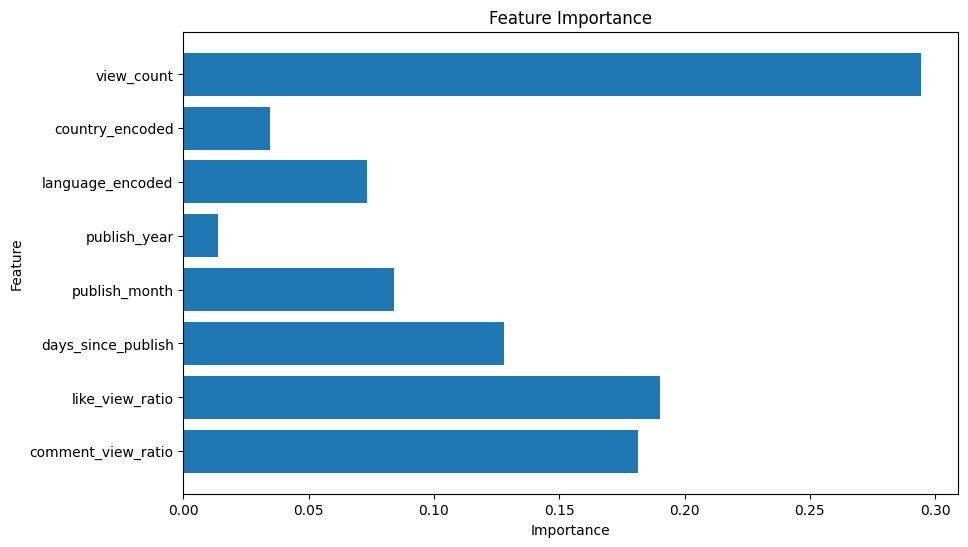

In [181]:
# Feature importance from the Random Forest model
importances = rf_model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


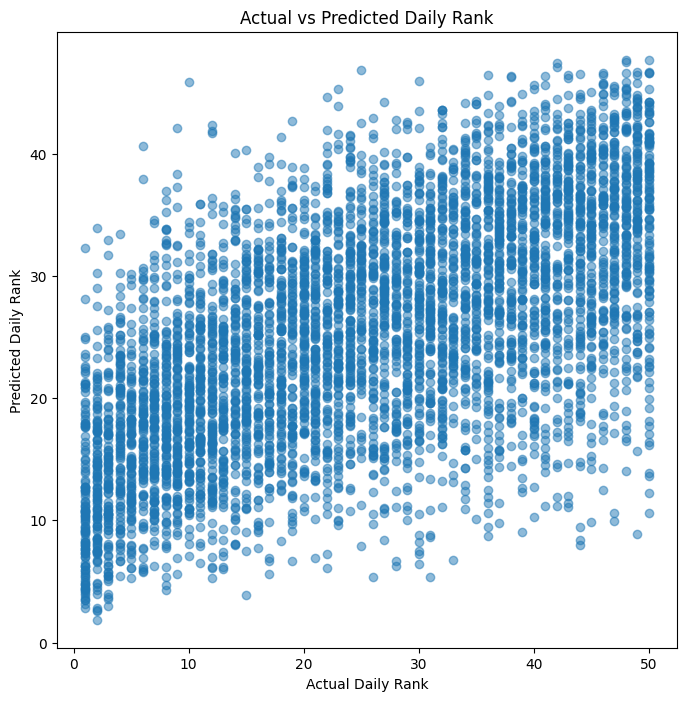

In [182]:
# Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Daily Rank")
plt.ylabel("Predicted Daily Rank")
plt.title("Actual vs Predicted Daily Rank")
plt.show()


In [183]:
# Initialize and train the model
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=10)
xgb_model.fit(X_train, y_train)

filename = 'xgboost_model.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

# Predictions
y_pred_xgb = xgb_model.predict(X_test)



In [184]:
# Metrics
print("XGBoost Forest Results")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R2 Score:", r2_score(y_test, y_pred_xgb))
evaluate_accuracy(y_pred_xgb, y_test)
evaluate_custom_error(y_pred_xgb, y_test)
evaluate_rank_metrics(y_pred_xgb, y_test)

XGBoost Forest Results
RMSE: 11.28259582372095
R2 Score: 0.3967864513397217
Accuracy: 36.18%
Weighted Accuracy: 72.05%
Spearman's Rank Correlation: 0.6289
Kendall's Tau: 0.4614
nDCG: 0.9745
